<a href="https://www.kaggle.com/code/dewizzz/lalalayeyeyelulusfixed?scriptVersionId=138655296" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="background-color:#F0E68C;font-family:Halvetica;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Deteksi Autisme</b></h1>

In [1]:
import os
import time
import torch
import torchvision
import pandas as pd
import numpy as np
import seaborn as sn
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Load Data**

In [2]:
# Data Train
Train_0 = '/kaggle/input/abideii/train/control'
Train_1 = '/kaggle/input/abideii/train/autism'

# Data Test
Test_0 = '/kaggle/input/abideii/val/control'
Test_1 = '/kaggle/input/abideii/val/autism' 

> **Labelling**

In [3]:
label_train = {}
label_test = {}
label_val = {}

# Melabeli data train
for file in os.listdir(Train_0):
    if file.endswith('.png'):
        label_train[file] = 0 

for file in os.listdir(Train_1):
    if file.endswith('.png'):
        label_train[file] = 1
        
        
# Melabeli data test
for file in os.listdir(Test_0):
    if file.endswith('.png'):
        label_test[file] = 0 

for file in os.listdir(Test_1):
    if file.endswith('.png'):
        label_test[file] = 1
        

In [4]:
# Mencetak hasil labeling untuk 1 gambar dari setiap kelas
count_train_0 = 0
count_train_1 = 0
count_test_0 = 0
count_test_1 = 0

for file, label in label_train.items():
    if label == 0 and count_train_0 < 2:
        print(f"File: {file}, Label: {label}")
        count_train_0 += 1
    elif label == 1 and count_train_1 < 2:
        print(f"File: {file}, Label: {label}")
        count_train_1 += 1

    if count_train_0 == 1 and count_train_1 == 1:
        break
        
for file, label in label_test.items():
    if label == 0 and count_test_0 < 2:
        print(f"File: {file}, Label: {label}")
        count_test_0 += 1
    elif label == 1 and count_test_1 < 2:
        print(f"File: {file}, Label: {label}")
        count_test_1 += 1
    if count_test_0 == 1 and count_test_1 == 1:
        break

File: 154529001-202.png, Label: 0
File: 606630160-736.png, Label: 0
File: 369629392-345.png, Label: 1
File: 421329587-190.png, Label: 1
File: 501229594-253.png, Label: 0
File: 580429914-67.png, Label: 0
File: 492829741-947.png, Label: 1
File: 430629609-199.png, Label: 1


In [5]:
# Define a custom transform for Canny edge detection
class GIFToTensor(object):
    def __call__(self, pic):
        if pic.mode != 'RGB':
            pic = pic.convert('RGB')
        return transforms.ToTensor()(pic)


# Transformasi data
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(205),
    transforms.Resize(224),
    GIFToTensor(),
])

# Proses transformasi dan penyimpanan data
data_train = []
data_test = []

for file, label in label_train.items():
    img_path = os.path.join(Train_0 if label == 0 else Train_1, file)
    image = Image.open(img_path)
    transformed_image = transform(image)

    # Simpan data dan label ke dalam list
    data_train.append((transformed_image, label))
    
for file, label in label_test.items():
    img_path = os.path.join(Test_0 if label == 0 else Test_1, file)
    image = Image.open(img_path)
    transformed_image = transform(image)
    
    data_test.append((transformed_image, label))

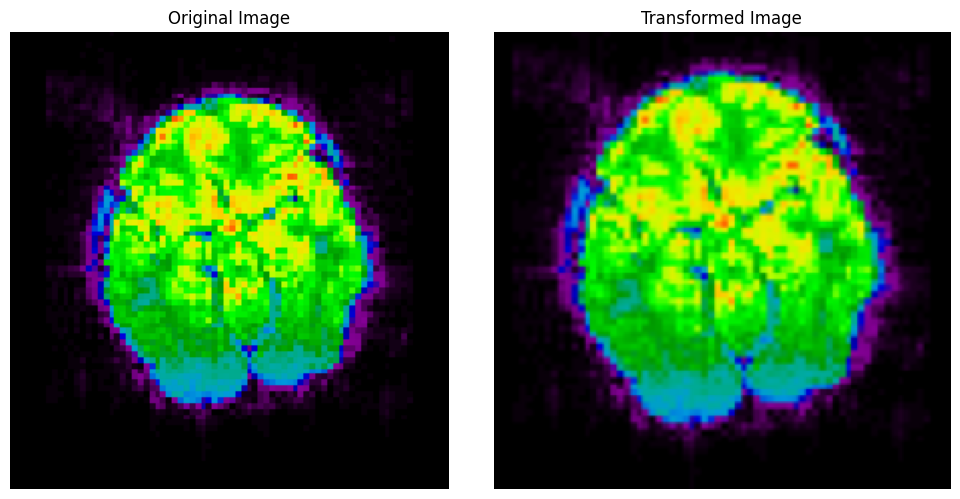

In [6]:
# Open and apply the transformation
image = Image.open(img_path)
transformed_image = transform(image)

# Display both original and transformed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")

# Convert the transformed tensor back to an image for display
transformed_image_as_img = transforms.ToPILImage()(transformed_image)
axs[1].imshow(transformed_image_as_img)
axs[1].set_title("Transformed Image")
axs[1].axis("off")

plt.tight_layout()
plt.show()

# **Split Data**

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Bagi data menjadi set pelatihan dan set pengujian
data_train, data_val, label_train, label_val = train_test_split(
    [item[0] for item in data_train],  # Data gambar
    [item[1] for item in data_train],  # Label
    test_size=0.3,  # Proporsi set pengujian
    random_state=42  # Seed untuk reproduktibilitas
)

# Cetak jumlah data dalam set pelatihan dan set pengujian
print(f"Jumlah data pelatihan: {len(data_train)}")
print(f"Jumlah data validasi: {len(data_val)}")

Jumlah data pelatihan: 5971
Jumlah data validasi: 2560


# **Check Data**

In [9]:
# Cetak jumlah data dalam set pelatihan dan set pengujian
print(f"Jumlah data pelatihan: {len(data_train)}")
print(f"Jumlah data pengujian: {len(data_test)}")

Jumlah data pelatihan: 5971
Jumlah data pengujian: 2134


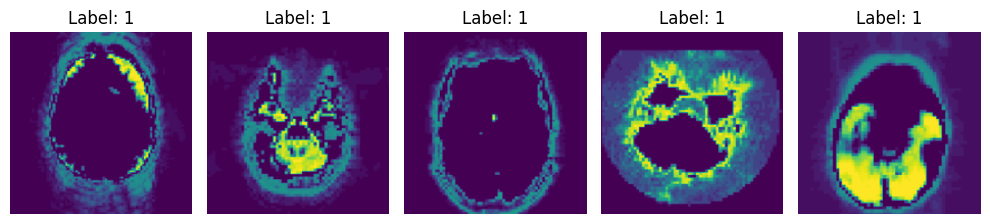

In [10]:
# Menampilkan 5 gambar dari set pelatihan
fig, axes = plt.subplots(1, 5, figsize=(10, 4))

for i, ax in enumerate(axes):
    img = data_train[i][0] # Mengubah dimensi tensor menjadi (H, W, C)
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
train_dataset = list(zip(data_train, label_train))
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

test_dataset = list(zip(data_test, list(label_test.values())))
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

val_dataset = list(zip(data_val, label_val))
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

> # **Modelling**

In [12]:
# Menginisialisasi model pretrained
model = models.vgg16(pretrained=True)

# Mengganti layer terakhir (fully connected) pada model dengan layer baru
num_classes = 2  # Jumlah kelas
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 94.0MB/s]


In [13]:
# Menggunakan perangkat GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
# Mendifinisikan fungsi loss dan optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# **Train Model**

In [15]:
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []


def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    running_loss = 0.0
    running_corrects = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        logits = output
        output = F.softmax(output, dim=1)
        _, preds = torch.max(output, dim=1)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
        running_loss += loss.item()
        running_corrects += torch.sum(preds == target).item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects / len(train_loader.dataset)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    print(epoch_loss)
    print(epoch_acc)
    
def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits = output
            val_loss += criterion(logits, target).item() # sum up batch loss
            pred_prob = torch.softmax(logits, dim=1) # apply softmax to output
            pred_class = torch.argmax(pred_prob, dim=1) # get the index of the max probability
            correct += pred_class.eq(target.view_as(pred_class)).sum().item()
    val_acc= correct/len(val_loader.dataset)
    val_loss /= len(val_loader)
    valid_loss.append(val_loss)
    valid_accuracy.append(val_acc)
    print(val_loss)
    print(val_acc)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))

In [16]:
num_epoch = 5
start_time = 0

for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        val(model, device, val_loader)
        

print("--- %s seconds ---" % (time.time() - start_time))

  0%|          | 0/187 [00:00<?, ?it/s]

0.678601832632075
0.5806397588343661
0.6401732996106148
0.64921875

Test set: Average loss: 0.6402, Accuracy: 1662/2560 (65%)



  0%|          | 0/187 [00:00<?, ?it/s]

0.6368626591993526
0.6273656004019427
0.6630043882876635
0.631640625

Test set: Average loss: 0.6630, Accuracy: 1617/2560 (63%)



  0%|          | 0/187 [00:00<?, ?it/s]

0.5960304929929621
0.6660525875062804
0.5950877893716097
0.694921875

Test set: Average loss: 0.5951, Accuracy: 1779/2560 (69%)



  0%|          | 0/187 [00:00<?, ?it/s]

0.5388164832630259
0.7054094791492213
0.542732335999608
0.6984375

Test set: Average loss: 0.5427, Accuracy: 1788/2560 (70%)



  0%|          | 0/187 [00:00<?, ?it/s]

0.4636232972463822
0.7703902193937364
0.5197304300963879
0.72109375

Test set: Average loss: 0.5197, Accuracy: 1846/2560 (72%)

--- 1697551704.286251 seconds ---


num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # Set model ke mode pelatihan
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        running_loss += loss.item()
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy}, Loss: {running_loss/len(train_loader)}")

# **Test Model**

In [17]:
model.eval()  # Set model ke mode evaluasi
correct = 0
total = 0

with torch.no_grad():
    for (inputs, labels) in test_loader:
        data, label = inputs[0].to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 72.07122774133083%


In [18]:
dictionary = {
    'train_loss':train_loss,
    'train_accuracy':train_accuracy,
    'val_loss':valid_loss,
    'val_accuracy':valid_accuracy
}
metrics = pd.DataFrame(dictionary)
metrics

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.678602,0.580640,0.640173,0.649219
1,0.636863,0.627366,0.663004,0.631641
2,0.596030,0.666053,0.595088,0.694922
3,0.538816,0.705409,0.542732,0.698438
4,0.463623,0.770390,0.519730,0.721094


# **Evaluasi Model**

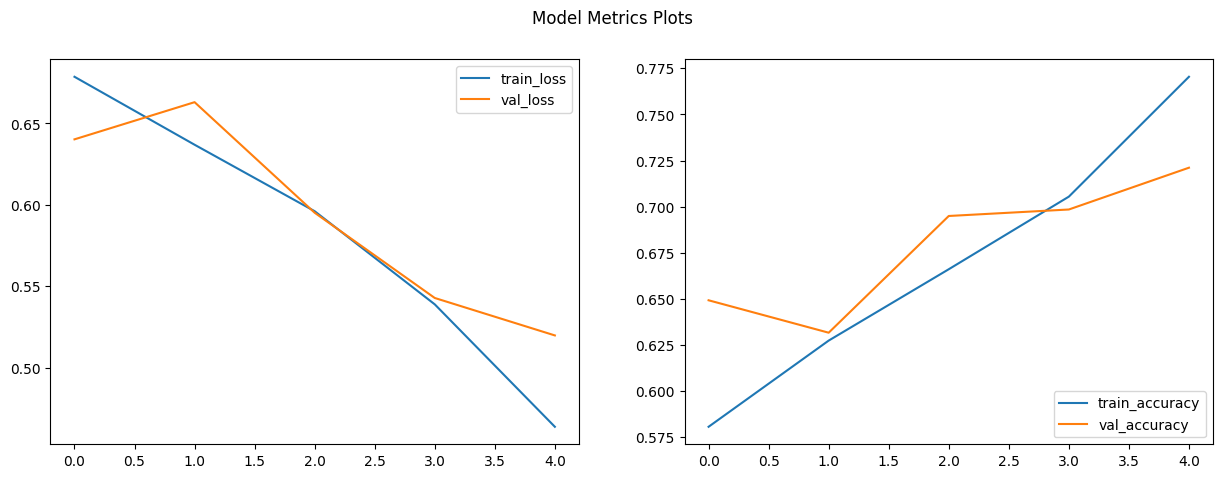

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Metrics Plots')

ax1.plot(metrics[['train_loss', 'val_loss']])
ax1.legend(['train_loss', 'val_loss'], loc="upper right")

ax2.plot(metrics[['train_accuracy', 'val_accuracy']])
ax2.legend(['train_accuracy', 'val_accuracy'], loc="lower right");

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = []
y_true = []

for data, labels in test_loader:
        data = data[0].to(torch.device('cuda'))
        output = model(data) # Feed Network
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

classes = ("Normal", "Autisme")

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1162
           1       0.71      0.66      0.68       972

    accuracy                           0.72      2134
   macro avg       0.72      0.72      0.72      2134
weighted avg       0.72      0.72      0.72      2134



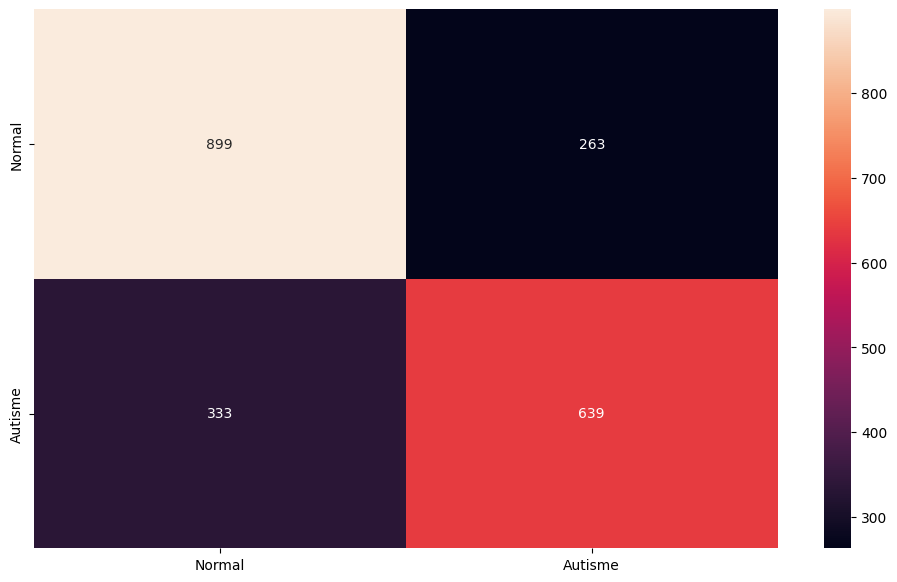

In [21]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, fmt="d",annot=True)
print(classification_report(y_true, y_pred))

torch.save(model.state_dict(), 'VGG16_EPIplot.pth')